# Version 7

Updated with many wrapped functions. Support for many feature generations

In [1]:
EXP_NAME = "DARTS_NBEATS_v7"
EXT_NAME = "generic_af"               # <--- Change this
EPOCHS = 50 #nb
LOOKBACK = 180 # same ratio as 60/10
FORWARD = 30

IND_VIEW = slice(450, 500) # a slice

In [2]:
# False --> Retrain
LOAD = False
# False --> Retrain
SAVE = False
# False --> univar
COVS = False
# False --> Train, val, and OOS, else, just Train and then forecast on OOS
OOS = True

In [3]:
#======Core============
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
#======PytorchLightning===========
import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping
# from pytorch_lightning.plugins import DDPPlugin
from pytorch_lightning import Trainer
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.callbacks import Callback
#======Darts===========
from darts.models import NBEATSModel
from darts import TimeSeries
from darts.dataprocessing.transformers import Scaler
from darts.utils.timeseries_generation import datetime_attribute_timeseries
#======UEXP============
from ue.uexp.dataprocessing.processor_binance import BinanceProcessor
from ue.uexp.dataprocessing.func import *
#from ue.uexp.dataprocessing.ta import *
#from ue.uexp.models.util import *
#======TA==============
from ta.momentum import *
from ta.trend import *
from ta.volatility import *
from ta.wrapper import *
import ta

import warnings
warnings.filterwarnings('ignore')

import fnmatch as fm
from typing import List

import time
from datetime import timedelta
startTime = time.time()

Importing plotly failed. Interactive plots will not work.


In [4]:
# Plot Params
plt.rcParams["figure.figsize"] = (15,10)

# Data Processing
update: throw everything in a class

## Class where everything is processed

In [5]:
class DataCreation():
    def __init__(self, start: str, end: str, ticker: List[str], features: dict):
        self.start = start
        self.end = end
        self.ticker = ticker
        self.features = features

        self._getRaw(start, end, ticker)
        if features:
            self.sRSIs = pd.DataFrame()
            self._build_covs(features)
        #otherwise univar experiment
        self._splitnscale()

    def _getRaw(self, s, e, tic):
        print("downloading raw data")
        p = BinanceProcessor("binance")
        self.df = p.download_data(tic, s, e, "1s")

    def _build_covs(self, features):
        """
        where dict(features = feature_name: feature_params
        currently supports the following:
        {
            srsi: {
                windows: w1, ... wn
                smooths: s1, ... sn
            },
        }
        """
        self.convF_ts = pd.DataFrame()

        if "srsi" in features:
            print("building stochastic rsi features")
            self.build_sRSIs(features["srsi"])
        
        if "macd" in features:
            pass

        if "timedm" in features:
            # time domain features (second, minute, etc)
            # covariates = datetime_attribute_timeseries(ts_covF, attribute="minute", one_hot=True)
            pass

    def _splitnscale(self, oos=True):
        """
        splits and scales and saves it to itself

        """
        self.series_ts = TimeSeries.from_dataframe(self.df[['close']])
        self.series_ts = self.series_ts.astype(np.float32)

        try:
            self.covF_ts = TimeSeries.from_dataframe(self.covF_ts)
            self.covF_ts = self.covF_ts.astype(np.float32)
        except Exception as e:
            #no covars, is univar only
            pass

        
        if oos:
            tr_oos_split = 1 - (FORWARD)/len(self.series_ts)

            self.series_scaler = Scaler()
            self.cov_scaler = Scaler()

            self.series_ts_tr, self.series_ts_oos = self.series_ts.split_after(tr_oos_split)
            self.series_ts_tr_scaled = self.series_scaler.fit_transform(self.series_ts_tr) 
            self.series_ts_oos_scaled = self.series_scaler.transform(self.series_ts_oos)

            try:
                self.p_cov_ts_tr, self.p_cov_ts_oos = self.ts_covF.split_after(self.tr_oos_split)
                self.p_cov_ts_tr_scaled = self.cov_scaler.fit_transform(self.p_cov_ts_tr)
                self.p_cov_ts_oos_scaled = self.cov_scaler.transform(self.p_cov_ts_oos) #may be incorrect, may need covs to cover some past
            except Exception as e:
                # univar
                pass


            # covariates darts can pinpoint which to use by index so skip splitting
           

            assert len(self.series_ts_oos_scaled) == FORWARD
    
    def get_for_oos(self):
        # returns all needed
        return self.series_ts_tr, self.series_ts_oos, self.series_ts_tr_scaled, self.series_ts_oos_scaled

    def get_scalers(self):
        # return for inverse transforms
        return self.series_scaler, self.cov_scaler
        

    def build_sRSIs(self, srsi):

        for w in srsi["windows"]:
            #print("Window:", w)
            # add the pure sRSI (no smoothing)
            indicator_srsi = ta.momentum.StochRSIIndicator(
                    close=self.df["close"], window=w, fillna=True
                )
            self.sRSIs = pd.concat([self.sRSIs,  indicator_srsi.stochrsi().rename("sRSI_w{}".format(w))], axis=1)

            for s in srsi["smooths"]:
                s = int(s*w)
                #print("Smooth:", s)
                # add multiple smoothing to given window of sRSI
                indicator_srsi = ta.momentum.StochRSIIndicator(
                    close=self.df["close"], window=w, smooth1=s, fillna=True
                )
                self.sRSIs = pd.concat([self.sRSIs, indicator_srsi.stochrsi_k().rename("sRSI_w{}_ma{}".format(w,s))], axis=1)
    
    
    def get_strain_series(self):
        return self.series_ts_tr_scaled

    def get_train_series(self):
        return self.series_ts_tr

    def get_train_covFs(self):
        return self.p_cov_ts_tr_scaled

    def get_test_series(self):
        return self.series_ts_oos

    # def get_train_covFs(self):
    #     return self.p_cov_ts_tr_scaled

    def show_sRSIs(self, ind_view=IND_VIEW):
        # plot for each w and ma's 
        for w in self.features["srsi"]["windows"]:
            for col in [c for c in self.sRSIs.columns if (c.endswith("w{}".format(w)) or fm.fnmatch(c, "sRSI_w{}_ma*".format(w)))]:
                plt.title("sRSI window: {} with various rolling".format(w))
                plt.plot(self.sRSIs[col][ind_view], label=col)
                plt.xlabel("Time (s)")
                plt.ylabel("value (0-1)")
                plt.legend()
            plt.show()

In [6]:
features = {
    "srsi": {
        "windows": [15, 30, 60, 120, 300, 600, 1800, 3600],
        "smooths": [0.1, 0.25, 0.5, 0.75, 1, 1.5, 2, 3, 5]
    },
    # "macd": {
        
    # }
}

In [7]:
data = DataCreation("2022-02-20", "2022-02-21", ["BTCUSDT"], features)

downloading raw data
Found 1 symbols
[1/1] - start download daily BTCUSDT aggTrades 

file already exists! ./cache/tick_raw/BTCUSDT-aggTrades-2022-02-19.csv

file already exists! ./cache/tick_raw/BTCUSDT-aggTrades-2022-02-20.csv

file already exists! ./cache/tick_raw/BTCUSDT-aggTrades-2022-02-21.csv
building stochastic rsi features


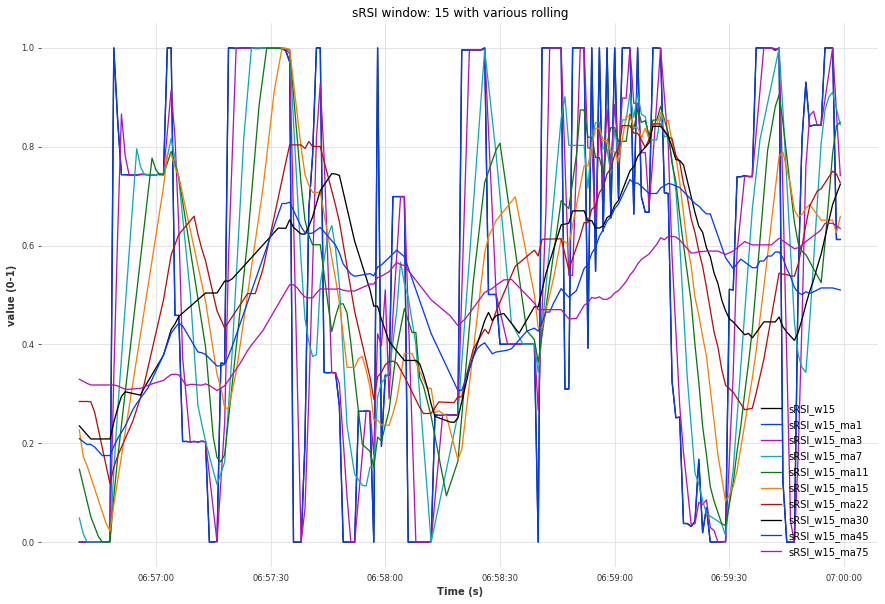

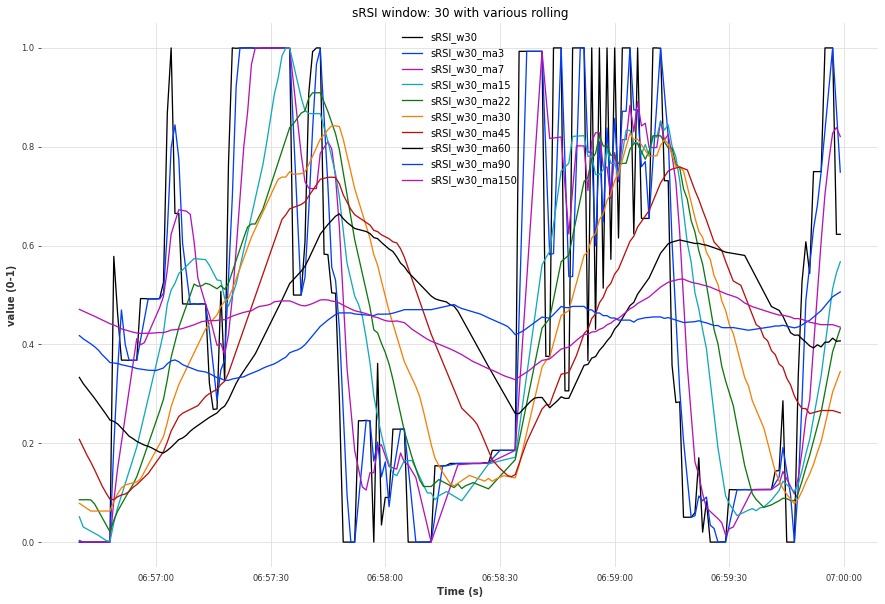

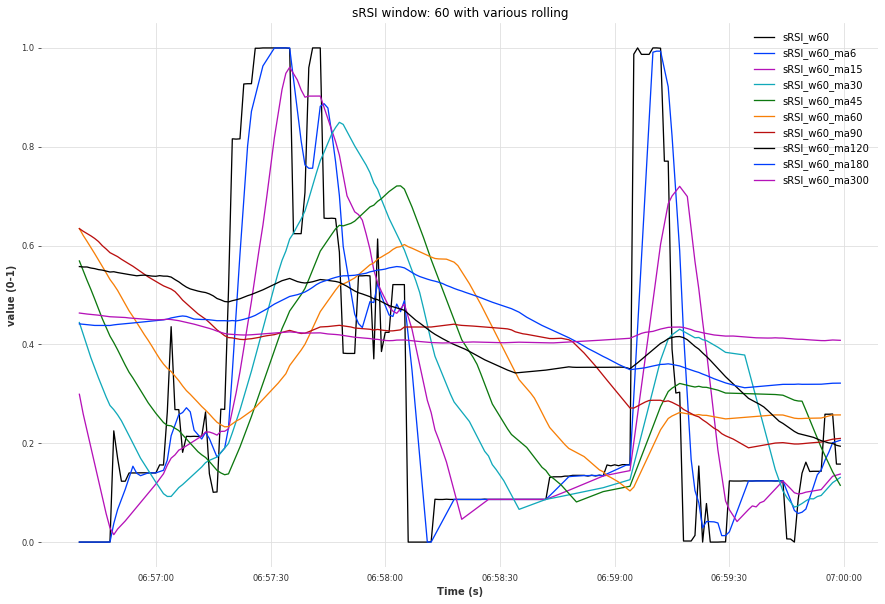

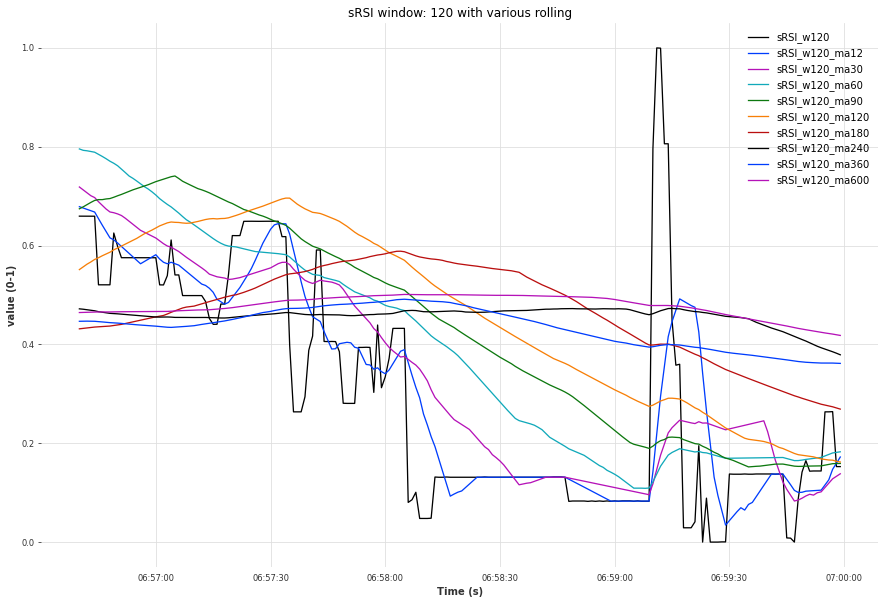

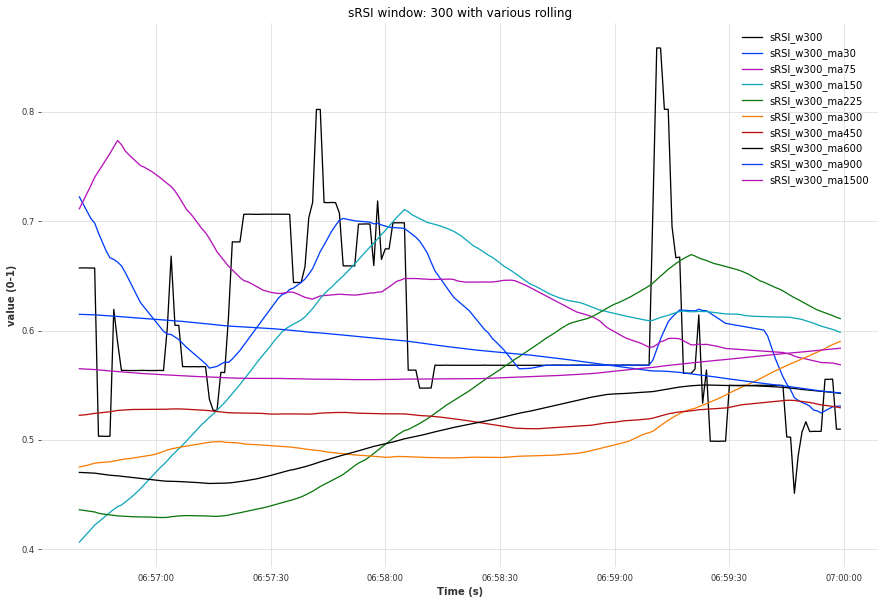

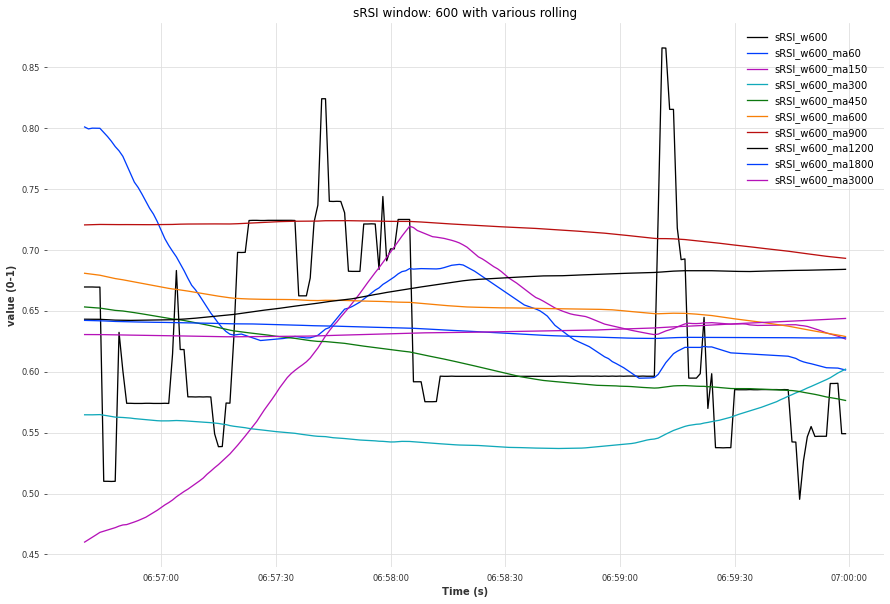

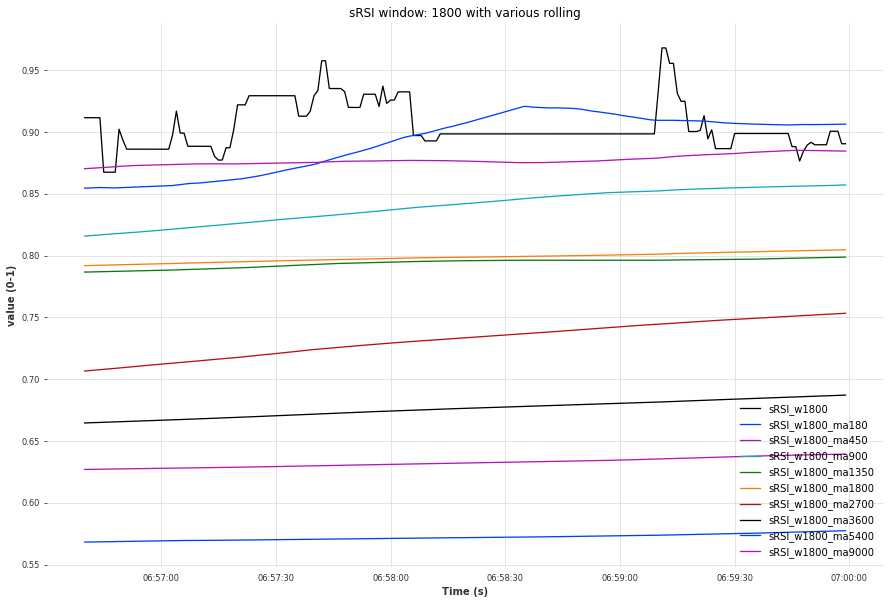

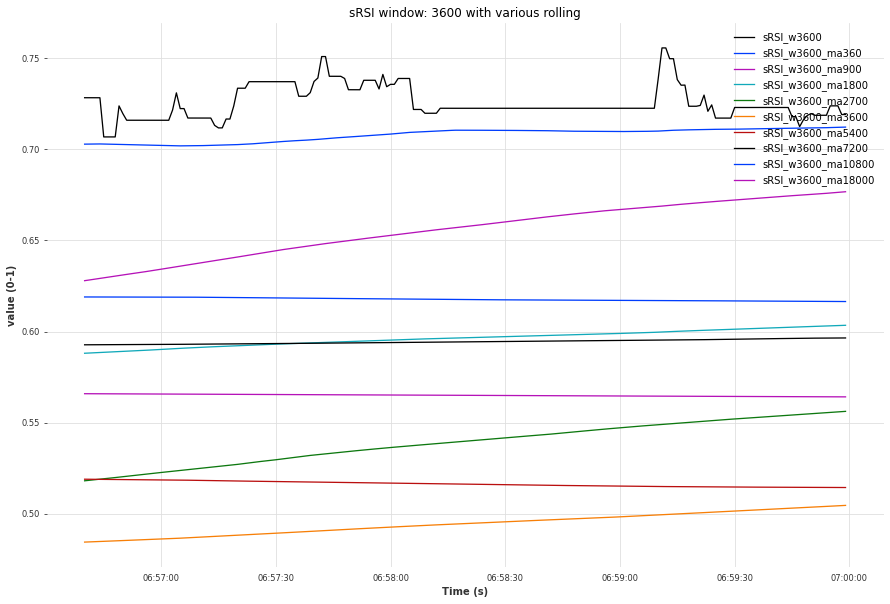

In [8]:
# slice(25000, 50000) to visualize for long windows (1800, 3600)
# slice(25000, 26000) to visualize for medium windows (120, 300, 600)
# slice(25000, 25200) to visualize for short windows (15, 30, 60)
data.show_sRSIs(slice(25000, 25200))

## Indicators

### Stochastic RSI

[Theory](https://school.stockcharts.com/doku.php?id=technical_indicators:stochrsi):

StochRSI= $\frac{RSI−min[RSI]}{max[RSI]−min[RSI]}$

- StochRSI is like RSI on steroids. RSI produces relatively fewer signals and StochRSI dramatically increases the signal count.

- StochRSI is an indicator of an indicator, which makes it the second derivative of price

%K is the indicator, %D is the (3day) moving avg of the indicator (but we can make it any X day)

BUT! ta package calculates the srsi as srsi, srsi_k as a smooth1 moving average of srsi, and srsi_d as a smooth2 moving average of srsi_k...

14-day StochRSI would be considered a short-term indicator

Therefore, it is important to identify the medium-term trend when looking for overbought and oversold conditions.

How to interpret it for a 14 (N) day sRSI:
- 14-day StochRSI equals 0 when RSI is at its lowest point for 14 days.
- 14-day StochRSI equals 1 when RSI is at its highest point for 14 days.
- 14-day StochRSI equals .5 when RSI is in the middle of its 14-day high-low range.
- 14-day StochRSI equals .2 when RSI is near the low of its 14-day high-low range.
- 14-day StochRSI equals .80 when RSI is near the high of its 14-day high-low range.


For example, a 10-day simple moving average of the StochRSI can produce an indicator that's much smoother and more stable.
Momentum favors rising prices when the 10-day SMA of StochRSI is above .50 and falling prices when below .50.


Try using a 5day sRSI with a 20day sRSI





### sRSI Observations:
- for shorter windows (such as 15), 5x barely/rarely touches 0.2/0.8 and 10x is too flat so best max to just 3x
- for medium windows (such as 60), much more smoothed out since reaching local 60 historic minmax is much more unlikely/slowly
- for long windows (such as 600, 1800, 3600), much less signals (obviously)

## MACD
[Theory](https://school.stockcharts.com/doku.php?id=technical_indicators:moving_average_convergence_divergence_macd)

MACD_Line = 12DayEMA - 26DayEMA

MACD_Signal = 9-day EMA of MACD_Line

Turns two trend-following indicators, moving averages, into a momentum oscillator by subtracting the longer moving average from the shorter one. As a result, the MACD offers the best of both worlds: trend following and momentum. 
Is a trend-following momentum indicator that shows the relationship between two moving averages of prices.

Key Interpretation: oscillates around 0 line, if > 0: This means upside momentum is increasing, if < 0: This means downside momentum is increasing.


Tips: Chartists looking for more sensitivity may try a shorter short-term moving average and a longer long-term moving average. MACD(5,35,5) is more sensitive than MACD(12,26,9) and might be better suited for weekly charts.

In [8]:
# # MACD
# indicator_macd = MACD(
#     close=df["close"], window_slow=35, window_fast=5, window_sign=5, fillna=True
# )
# df["trend_macd"] = indicator_macd.macd()
# df["trend_macd_signal"] = indicator_macd.macd_signal()
# df["trend_macd_diff"] = indicator_macd.macd_diff()

In [9]:
# IND_VIEW = slice(0,20000)

In [10]:
# plt.plot(df["trend_macd"][IND_VIEW], label="macd")
# plt.plot(df["trend_macd_signal"][IND_VIEW], label="macd signal")
# plt.plot(df["trend_macd_diff"][IND_VIEW], label="macd diff")
# plt.legend()

In [11]:
# min(df["trend_macd"])

### TSI (momentum)

In [ ]:
# # TSI Indicator (momentum)
# df["momentum_tsi"] = TSIIndicator(
#     close=df["close"], window_slow=25, window_fast=13, fillna=True
# ).tsi()/100 #scale 0-1

In [12]:
# plt.figure(figsize=(15,10))
# plt.plot(df["momentum_tsi"][:IND_VIEW], label="tsi")
# plt.legend()

### Volume Indicators

In [13]:
# # Chaikin Money Flow
# df["volume_cmf"] = ChaikinMoneyFlowIndicator(
#     high=df["high"], low=df["low"], close=df["close"], volume=df["volume"], fillna=True
# ).chaikin_money_flow()

# # Money Flow Index
# df["volume_mfi"] = MFIIndicator(
#             high=df["high"], low=df["low"], close=df["close"], volume=df["volume"], fillna=True
#         ).money_flow_index()/100 #norm to 0-1

# # Force Index
# df["volume_fi"] = ForceIndexIndicator(
#     close=df["close"], volume=df["volume"], window=13, fillna=True
# ).force_index() # NOT NORMALIZED

# # Volume Weighted Average Price
# df["volume_vwap"] = VolumeWeightedAveragePrice(
#     high=df["high"], low=df["low"], close=df["close"], volume=df["volume"], fillna=True,
#     window=14,
# ).volume_weighted_average_price()

In [14]:
# plt.figure(figsize=(15,10))
# plt.plot(df["volume_cmf"][:IND_VIEW], label="volume_cmf")
# plt.plot(df["volume_mfi"][:IND_VIEW], label="macd volume_mfi")
# # plt.plot(df["volume_fi"][:IND_VIEW], label="volume_fi")
# # plt.plot(df["volume_vwap"][:IND_VIEW], label="volume_vwap")
# plt.legend()

### Force Index

In [15]:
# plt.figure(figsize=(15,10))
# plt.plot(df["volume_fi"][:IND_VIEW], label="volume_fi")
# plt.legend()

### VWAP

In [16]:
# plt.figure(figsize=(15,10))
# plt.plot(df["volume_vwap"][:IND_VIEW], label="volume_vwap")
# plt.legend()

### SMA, EMA

In [17]:
# # SMAs
# df["trend_sma_fast"] = SMAIndicator(
#     close=df["close"], window=12, fillna=True
# ).sma_indicator()
# df["trend_sma_slow"] = SMAIndicator(
#     close=df["close"], window=26, fillna=True
# ).sma_indicator()

# # EMAs
# df["trend_ema_fast"] = EMAIndicator(
#     close=df["close"], window=12, fillna=True
# ).ema_indicator()
# df["trend_ema_slow"] = EMAIndicator(
#     close=df["close"], window=26, fillna=True
# ).ema_indicator()

In [18]:
# plt.figure(figsize=(15,10))
# plt.plot(df["trend_sma_fast"][:IND_VIEW], label="trend_sma_fast")
# plt.plot(df["trend_sma_slow"][:IND_VIEW], label="trend_sma_slow")
# plt.plot(df["trend_ema_fast"][:IND_VIEW], label="trend_ema_fast")
# plt.plot(df["trend_ema_slow"][:IND_VIEW], label="trend_ema_slow")
# plt.legend()

In [19]:
# plt.figure(figsize=(15,10))
# plt.plot(df["close"][:IND_VIEW], label="close")
# plt.legend()

### tr-val-te

In [ ]:
# def prep_tr_val_te():
#     tr_valte_split = 1- (LOOKBACK+FORWARD+1+FORWARD)/len(series_ts)

#     series_scaler = Scaler()
#     cov_scaler = Scaler()

#     series_ts_tr, series_ts_valte = series_ts.split_after(tr_valte_split)
#     p_cov_ts_tr, p_cov_ts_valte = ts_covF.split_after(tr_valte_split)

#     val_te_split = 1 - (FORWARD/len(series_ts_valte))

#     #split valte -> val, test: Each has FORWARD number of points
#     series_ts_val, series_ts_te = series_ts_valte.split_after(val_te_split)
#     p_cov_ts_val, p_cov_ts_te = p_cov_ts_valte.split_after(val_te_split) 

#     series_ts_tr_scaled = series_scaler.fit_transform(series_ts_tr) 
#     p_cov_ts_tr_scaled = cov_scaler.fit_transform(p_cov_ts_tr)

#     series_ts_val_scaled = series_scaler.transform(series_ts_val)
#     p_cov_ts_val_scaled = cov_scaler.transform(p_cov_ts_val)

#     series_ts_te_scaled = series_scaler.transform(series_ts_te)
#     p_cov_ts_te_scaled = cov_scaler.transform(p_cov_ts_te)
    
#     assert len(series_ts_val) == LOOKBACK+FORWARD+1
#     assert len(series_ts_te) == FORWARD
    
#     return series_ts_tr, series_ts_val, series_ts_te, series_ts_tr_scaled, p_cov_ts_tr_scaled, series_ts_val_scaled, p_cov_ts_val_scaled, series_ts_te_scaled, p_cov_ts_te_scaled, series_scaler, cov_scaler

In [ ]:
# series_ts_tr, series_ts_val, series_ts_te, series_ts_tr_scaled, p_cov_ts_tr_scaled, series_ts_val_scaled, p_cov_ts_val_scaled, series_ts_te_scaled, p_cov_ts_te_scaled, series_scaler, cov_scaler = prep_tr_val_te()

In [ ]:
# len(series_ts_tr_scaled)

172719

# Model

## Logging
https://github.com/unit8co/darts/issues/811

In [9]:
class LossLogger(Callback):
    # checkout pl.Callback hooks: https://pytorch-lightning.readthedocs.io/en/stable/extensions/callbacks.html
    def __init__(self):
        self.train_loss = []
        self.val_loss = []
        self.smt = []

    def on_train_epoch_end(self, trainer: "pl.Trainer", pl_module: "pl.LightningModule") -> None:
        self.train_loss.append(float(trainer.callback_metrics["train_loss"]))
        self.smt.append(trainer.callback_metrics)

    def on_validation_epoch_end(self, trainer: "pl.Trainer", pl_module: "pl.LightningModule") -> None:
        self.val_loss.append(float(trainer.callback_metrics["val_loss"]))

loss_logger = LossLogger()

custom lightning logger: https://pytorch-lightning.readthedocs.io/en/stable/extensions/logging.html?highlight=metric#automatic-logging

In [10]:
# logger = TensorBoardLogger(save_dir=os.getcwd(), version=1, name="lightning_logs")

In [11]:
# # Learning rate logger: https://pytorch-lightning.readthedocs.io/en/stable/extensions/generated/pytorch_lightning.callbacks.LearningRateMonitor.html#pytorch_lightning.callbacks.LearningRateMonitor
# from pytorch_lightning.callbacks import LearningRateMonitor
# lr_monitor = LearningRateMonitor(logging_interval='step')

## Early Stopping

In [12]:
# my_stopper = EarlyStopping(
#     monitor="val_loss",
#     patience=5,
#     min_delta=0.05,
#     mode='min',
# )

In [13]:
models = {
    "milk_model": NBEATSModel(
        input_chunk_length=24, 
        output_chunk_length=12, 
        # n_epochs=EPOCHS,
        batch_size=1024,
        model_name=EXP_NAME,
        log_tensorboard=True,
        nr_epochs_val_period=1, #required for val loss to be same size. somewhere in the code they set this to 10 by default despite them saying 1 is default
        pl_trainer_kwargs={
            "accelerator": "gpu",
            "gpus": [2],
            "enable_progress_bar": False,
            "callbacks": [loss_logger],
            # "logger": 
            }
        ),
    "divvy_interp": NBEATSModel(
        input_chunk_length=30,
        output_chunk_length=7,
        generic_architecture=False, #we use interpretable model to get trend and seasonality
        num_blocks=3,
        num_layers=4,
        layer_widths=512,
        # n_epochs=50,
        nr_epochs_val_period=1,
        # batch_size=800,
        model_name="nbeats_interpretable_run",
        pl_trainer_kwargs={
            "accelerator": "gpu",
            "gpus": [2],
            "enable_progress_bar": False,
            "callbacks": [loss_logger],
            # "logger": 
            }
    ),
    # and others
    # "heiko_kbeyond":
    "generic_af": NBEATSModel(
        model_name=EXP_NAME,
        input_chunk_length=LOOKBACK,
        output_chunk_length=FORWARD,
        generic_architecture=True,
        nr_epochs_val_period=1,
        batch_size=1024,
        pl_trainer_kwargs={
            "accelerator": "gpu",
            "gpus": [1],
            "auto_scale_batch_size": "binsearch", # <-- kwarg to pl.Trainer for finding optimal batch size s.t. no OOM
            "enable_progress_bar": False,
            "callbacks": [loss_logger],
            #"callbacks": [my_stopper],
        }
    ),
}

In [14]:
models['generic_af'].batch_size

1024

## Predict N Evaluate Helper
### Metrics
https://datasciencestunt.com/mean-directional-accuracy-of-time-series-forecast/ <br>
https://en.wikipedia.org/wiki/Forecasting#Forecasting_accuracy

In [15]:
# Mean Directional Accuracy: GET DIRECTIONS (UP/DOWN)

# ts, ts -> float
def mda(actual, pred):
    actual = actual.values()
    pred = pred.values()
    acc = np.round(np.mean(np.sign(actual[1:] - actual[:-1]) == np.sign(pred[1:] - pred[:-1])), 4)*100
    print("Directional accuracy: {}%".format(acc))
    return acc

# oos_acc = mda(series_ts_oos, pred)

In [16]:
from darts.metrics import *

# These arent plots bc I couldnt find how to integrate it with pytorchLightning so using Darts' function will just get a value
def get_scores(actual, forecasted):
    """
    should just be of the desired horizon (FORWARD)
        - mae score
        - mape score
        - mse score
        - ope (overall percentage error)
        - r2 score
        - rmse score
    """
    actual = actual[:FORWARD]
    forecasted = forecasted[:FORWARD]
    scores = {}
    
    scores["MDA"] = np.round(mda(actual, forecasted), 2)
    scores["MAE"] = np.round(mae(actual, forecasted), 2)
    scores["MAPE"] = np.round(mape(actual, forecasted), 2)
    scores["MSE"] = np.round(mse(actual, forecasted), 2)
    scores["OPE"] = np.round(ope(actual, forecasted), 2)
    scores["R2"] = np.round(r2_score(actual, forecasted), 2)
    scores["RMSE"] = np.round(rmse(actual, forecasted), 2)



    print("MDA:", np.round(mda(actual, forecasted), 2))
    print("MAE:", np.round(mae(actual, forecasted), 2))
    print("MAPE:", np.round(mape(actual, forecasted), 2), "%")
    print("MSE:", np.round(mse(actual, forecasted), 2))
    print("OPE:", np.round(ope(actual, forecasted), 2), "%")
    print("R2:", np.round(r2_score(actual, forecasted), 2))
    print("RMSE:", np.round(rmse(actual, forecasted), 2))

    return scores

### Plots

In [17]:
def visualize_forecast(prev, actual, forecast):
    plt.figure(figsize=(15, 10))
    # prev
    prev[-LOOKBACK:].plot(label="past {}s prices".format(LOOKBACK))
    # actual
    actual[:FORWARD].plot(label="actual prices")
    # forecast
    forecast[:FORWARD].plot(label="forecasted prices")

In [18]:
def show_losses(loss_logger):
    plt.figure(figsize=(15, 10))
    # skip 1st bc val has an extra one
    plt.plot(loss_logger.train_loss[1:], label="training loss")
    plt.plot(loss_logger.val_loss[1:], label="validation loss")
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

# TODO: define trainer manually!
only then can we incorporate more fancy things such as auto batch size

### Wrapper

In [19]:
OOS = True

In [20]:
def predict_n_evaluate(model, oos=OOS, covs=COVS, save=SAVE):
    """
    returns
        - pred
        - scores: dict
    """
    if oos and covs:
        # multivar oos
        print('fitting for FORWARD oos multivar')
        model.fit(
            series=data.get_strain_series(),
            past_covariates=data.get_train_covFs(),
            epochs=EPOCHS,
        )
        pred_scaled = model.predict(
            series=data.get_strain_series(), 
            past_covariates=data.get_train_covFs(),
            n=FORWARD)
    elif oos and not covs:
        # single univar
        print('fitting for FORWARD oos univar')
        model.fit(
            series=data.get_strain_series(),
            epochs=FORWARD,
        )
        pred_scaled = model.predict(series=data.get_strain_series(), n=FORWARD)
    else:
        # not there yet
        pass
    
    # NOTE: known bug of  module 'distutils' has no attribute 'version' as per https://stackoverflow.com/questions/70520120/attributeerror-module-setuptools-distutils-has-no-attribute-version

    # scale back pred
    series_scaler, covFs_scaler = data.get_scalers()
    pred = series_scaler.inverse_transform(pred_scaled)

    scores = get_scores(data.get_test_series(), pred)

    return pred, scores
    

In [21]:
pred, scores = predict_n_evaluate(models['generic_af'])

[2022-03-21 01:48:39,988] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 172561 samples.
[2022-03-21 01:48:39,988] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 172561 samples.
[2022-03-21 01:48:40,077] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 32-bits; casting model to float32.
[2022-03-21 01:48:40,077] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 32-bits; casting model to float32.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


fitting for FORWARD oos univar



  | Name      | Type       | Params
-----------------------------------------
0 | criterion | MSELoss    | 0     
1 | stacks    | ModuleList | 7.4 M 
-----------------------------------------
7.4 M     Trainable params
2.4 K     Non-trainable params
7.4 M     Total params
29.705    Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Predicting: 43it [00:00, ?it/s]

Directional accuracy: 55.169999999999995%
Directional accuracy: 55.169999999999995%
MDA: 55.17
MAE: 158.87
MAPE: 0.43 %
MSE: 35492.71
OPE: 0.42 %
R2: -282.66
RMSE: 188.4


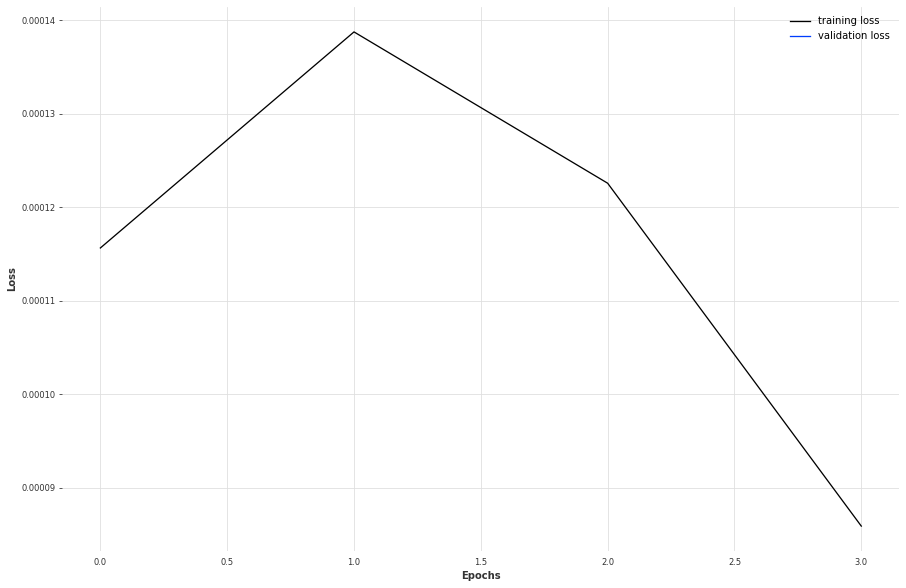

In [69]:
show_losses(loss_logger)

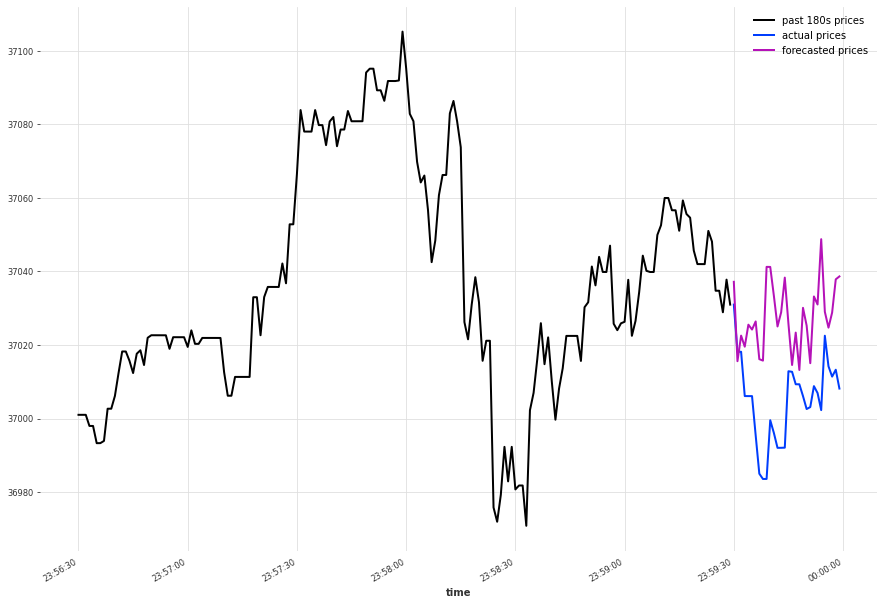

In [70]:
visualize_forecast(data.get_train_series(), data.get_test_series(), pred)

# SAVE MODEL

In [46]:
if SAVE:
    models['generic_af'].save_model(EXP_NAME+str(EPOCHS)+"_generic_af_OOS"+"_60-10"+".pth.tar")

# Execution Time (nbconvert)

In [71]:
executionTime = (time.time() - startTime)
print('Execution time in seconds: ' + str(executionTime))
print('Execution time:', str(timedelta(seconds=executionTime)))

Execution time in seconds: 1736.4877471923828
Execution time: 0:28:56.487747
